Here we look at the values inside all the tsl files from boss. We will see the distributions of parameters to understand exactly what they do. We will also have a couple of case studies about simple patches and how they work; they will be included as examples. The plan is to turn this into a mini tutorial for the people who wish to use the editor.

In [1]:
from os import listdir
from os.path import isfile, join
import json
from pathlib import Path


import matplotlib.pyplot as plt
import numpy as np

def load_liveset(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        patch_data = json.load(file)
    return patch_data



tsl_directory = Path( '../res')
files = [ 'Preset Patches.tsl','Classic SL-20 Collection.tsl', 'Expansion Packs 1_8.tsl']
livesets = []
for file_name in files:
    print(f'{file_name}')
    livesets.append(load_liveset(join(tsl_directory, file_name)))

Preset Patches.tsl
Classic SL-20 Collection.tsl
Expansion Packs 1_8.tsl


Now that we have the patches loaded, we will pry:

In [2]:
presets = livesets[0]
for key in presets.keys()  :
    if key != 'data':
        print(f'{key}: {presets[key]}')
print('\n --- data ---')
data = presets['data'][0][20]

for key in data.keys()  :
        print(f'{key}: {data[key]}')
print('\n')



name: Preset Patches
formatRev: 0001
device: SL-2

 --- data ---
memo: {'memo': '', 'isToneCentralPatch': True}
paramSet: {'PATCH%COM': ['53', '49', '4E', '47', '4C', '45', '20', '32', '2D', '31', '30', '20', '20', '20', '20', '20'], 'PATCH%SLICER(1)': ['32', '01', '05', '02', '64', '32', '32', '28', '00', '64', '32', '28', '32', '0F', '64', '32', '32', '29', '0F', '00', '32', '32', '32', '32', '32', '32', '32', '32', '64', '2C', '00', '64', '00', '64', '64', '64', '64', '64', '64', '64', '64', '64', '32', '32', '64', '64', '64', '64', '64', '64', '64', '64', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '64', '11', '43', '1A', '00', '23', '3B', '50', '64', '48', '25', '18', '32', '46', '64', '64', '32', '32', '32', '32', '32', '32', '32', '32', '0C', '0C', '0C', '0C', '0C', '0C', '0C', '0C', '0C', '0C', '0C', '0C', '0C', '0C', '0C', '0C', '0C', '0C', '0C', '0C', '0C', '0C', '0C', '0C'], '

In [2]:
import sl2.core as core

preset_patch = core.read_tsl (str( Path( '../res/Preset Patches.tsl')))

# the com parameter
print('com')
print(preset_patch.data[0][0].paramSet.com)
print(preset_patch.data[0][0].paramSet.com.string)

# the memo parameter
print(preset_patch.data[0][0].memo.memo)
preset_patch.data[0][0].memo.memo = "This is a test memo"
print(preset_patch.data[0][0].memo.memo)




com
[83 73 78 71 76 69 32 49 45 48 49 32 32 32 32 32]
SINGLE 1-01

This is a test memo


It would be challenging to depict every parameter individually here, so, instead, we will look at parameters differently, via histograms.

### For the slicer parameter, we only care about the effect type, so we can track it down as fx_type =2:

_pattern = 0
_enable = 1
**_fx_type = 2**
_step_number = 3
_step_length = slice(4, 28)
_step_level = slice(28, 52)
_band = slice(52, 76)
_effect = slice(76, 100)
_pitch = slice(100, 123)


In [4]:
def get_all_values_for_param(livesets, param_name, param_index=None):
    all_values = []
    patch_names=[]
    for liveset in livesets:
        for patch in liveset['data'][0]:
            if param_index is not None:
                param_value = hex_to_int(patch['paramSet'][param_name][param_index])
            else:
                param_value = [hex_to_int(i) for i in patch['paramSet'][param_name]]
            all_values.append(param_value)
            patch_names.append(hex_to_str(patch['paramSet']['PATCH%COM']))
    return all_values,patch_names

def hex_to_str(hex_array):
    return ''.join([chr(int(x, 16)) for x in hex_array]).rstrip()
def hex_to_int(hex_str):
    return int(hex_str, 16)



def plot_param_dist(param_index = 0,param_name = 'PATCH%SLICER(1)',hist_labels=None,title=None,n_vals=None,ax=None):
    
    param_values,param_names = get_all_values_for_param(livesets=livesets, param_name=param_name, param_index=param_index)

    if ax is None:
        return param_values,param_names

    if n_vals == None:
        n_vals=max([2,int(max(param_values)+1)])
        
    ax.hist(param_values, bins=np.arange(-0.5, n_vals+0.5,1), edgecolor='black')

    ax.set_title(title if title is not None else f'{param_name} [{param_index}]')
    if hist_labels is not None:
        _=ax.set_xticks(range(7), labels=[hist_labels[i] for i in range(7)], rotation=45)
    
    return param_values,param_names




# SLICER C1 EFFECTS

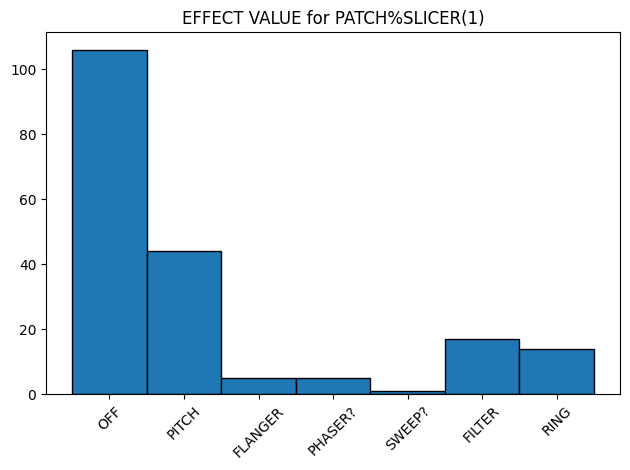

In [5]:
hist_labels={0:'OFF',
    1:'PITCH',
    2:'FLANGER', 
    3:'PHASER?', 
    4:'SWEEP?',
    5:'FILTER',
    6:'RING'}
title='EFFECT VALUE for PATCH%SLICER(1)'

fig, ax = plt.subplots(nrows=1, ncols=1)
param_values,param_names = plot_param_dist(2,'PATCH%SLICER(1)',hist_labels,title,ax=ax)
plt.tight_layout()
plt.show()


Now, to track this down completely, we will find out what the different patches sound like when they have each effect

In [6]:
effects_names ={i : [] for i in range(7)}
for i, name in enumerate(param_names):
    effects_names[param_values[i]].append(name)

print('Patches by EFFECT VALUE for PATCH%SLICER(1):')
for i in range(7):
    print(f'  {hist_labels[i]}: {effects_names[i]}')   

Patches by EFFECT VALUE for PATCH%SLICER(1):
  OFF: ['SINGLE 1-01', 'SINGLE 1-02', 'SINGLE 1-03', 'SINGLE 1-04', 'SINGLE 1-05', 'SINGLE 1-06', 'SINGLE 1-07', 'SINGLE 1-08', 'SINGLE 1-09', 'SINGLE 1-10', 'SINGLE 1-11', 'SINGLE 2-01', 'SINGLE 2-02', 'SINGLE 2-03', 'SINGLE 2-04', 'SINGLE 2-05', 'SINGLE 2-08', 'DUAL 3-01', 'DUAL 3-02', 'DUAL 3-04', 'DUAL 3-05', 'DUAL 3-09', 'DUAL 3-10', 'DUAL 4-01', 'DUAL 4-05', 'DUAL 4-07', 'DUAL 4-08', 'TREMOLO 5-01', 'TREMOLO 5-02', 'TREMOLO 5-03', 'TREMOLO 5-04', 'TREMOLO 5-05', 'TREMOLO 5-06', 'TREMOLO 5-08', 'TREMOLO 5-09', 'TREMOLO 5-11', 'HARMONIC 6-01', 'HARMONIC 6-02', 'HARMONIC 6-03', 'HARMONIC 6-04', 'HARMONIC 6-05', 'HARMONIC 6-06', 'HARMONIC 6-07', 'HARMONIC 6-08', 'HARMONIC 6-09', 'HARMONIC 6-11', 'SFX 7-01', 'SFX 7-03', 'SFX 7-08', 'SFX 7-10', 'SFX 8-01', 'SFX 8-10', 'SL-20_P01', 'SL-20_P02', 'SL-20_P03', 'SL-20_P04', 'SL-20_P05', 'SL-20_P06', 'SL-20_P07', 'SL-20_P08', 'SL-20_P09', 'SL-20_P10', 'SL-20_P11', 'SL-20_P12', 'SL-20_P13', 'SL-20_

# The above list is sufficient to figure out which parameter value corresponds to which effect in the slicer

# BEAT

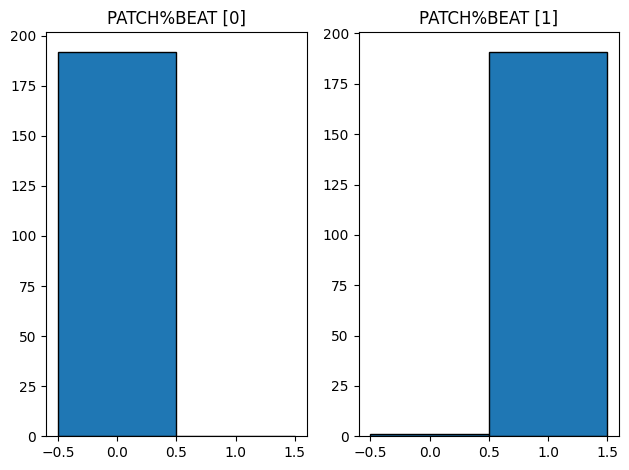

Patches by param 2 in beat:
  0: ['TREMOLO WAVE']
  1: ['SINGLE 1-01', 'SINGLE 1-02', 'SINGLE 1-03', 'SINGLE 1-04', 'SINGLE 1-05', 'SINGLE 1-06', 'SINGLE 1-07', 'SINGLE 1-08', 'SINGLE 1-09', 'SINGLE 1-10', 'SINGLE 1-11', 'SINGLE 2-01', 'SINGLE 2-02', 'SINGLE 2-03', 'SINGLE 2-04', 'SINGLE 2-05', 'SINGLE 2-06', 'SINGLE 2-07', 'SINGLE 2-08', 'SINGLE 2-09', 'SINGLE 2-10', 'SINGLE 2-11', 'DUAL 3-01', 'DUAL 3-02', 'DUAL 3-03', 'DUAL 3-04', 'DUAL 3-05', 'DUAL 3-06', 'DUAL 3-07', 'DUAL 3-08', 'DUAL 3-09', 'DUAL 3-10', 'DUAL 3-11', 'DUAL 4-01', 'DUAL 4-02', 'DUAL 4-03', 'DUAL 4-04', 'DUAL 4-05', 'DUAL 4-06', 'DUAL 4-07', 'DUAL 4-08', 'DUAL 4-09', 'DUAL 4-10', 'DUAL 4-11', 'TREMOLO 5-01', 'TREMOLO 5-02', 'TREMOLO 5-03', 'TREMOLO 5-04', 'TREMOLO 5-05', 'TREMOLO 5-06', 'TREMOLO 5-07', 'TREMOLO 5-08', 'TREMOLO 5-09', 'TREMOLO 5-10', 'TREMOLO 5-11', 'HARMONIC 6-01', 'HARMONIC 6-02', 'HARMONIC 6-03', 'HARMONIC 6-04', 'HARMONIC 6-05', 'HARMONIC 6-06', 'HARMONIC 6-07', 'HARMONIC 6-08', 'HARMONIC 6-09',

In [7]:


fig, ax_list = plt.subplots(ncols=2)
plot_param_dist(0,'PATCH%BEAT',ax=ax_list[0])


param_values,param_names=plot_param_dist(1,'PATCH%BEAT',ax=ax_list[1],n_vals=2)

effects_names ={i : [] for i in range(2)}
for i, name in enumerate(param_names):
    effects_names[param_values[i]].append(name)
plt.tight_layout()
plt.show()

print('Patches by param 2 in beat:')
for i in range(2):
    print(f'  {i}: {effects_names[i]}')   



# DIVIDER

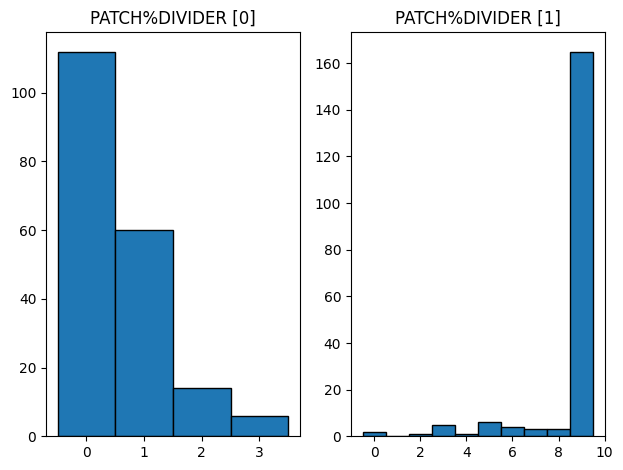

In [8]:

fig, ax = plt.subplots(ncols=2)

plot_param_dist(0,'PATCH%DIVIDER',ax=ax[0])
param_values,param_names=plot_param_dist(1,'PATCH%DIVIDER',n_vals=10,ax=ax[1])
plt.tight_layout()
plt.show()

# NOISE SUPPRESSOR

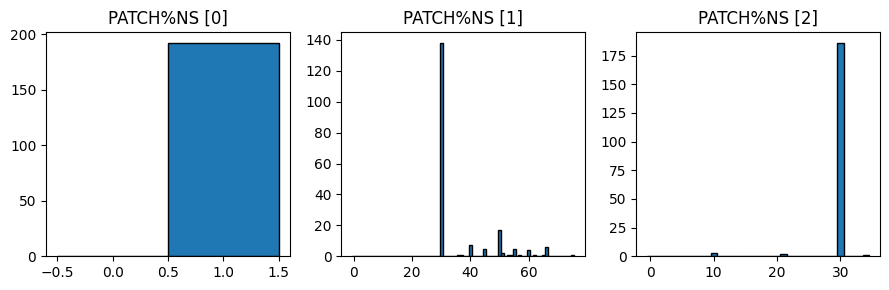

In [9]:
fig, ax = plt.subplots(ncols=3, figsize=(3*3,3))
param_name='PATCH%NS'
for i in range(3):
    
    param_values,param_names=plot_param_dist(i,param_name,ax=ax[i])
plt.tight_layout()
plt.show()

# MIXER

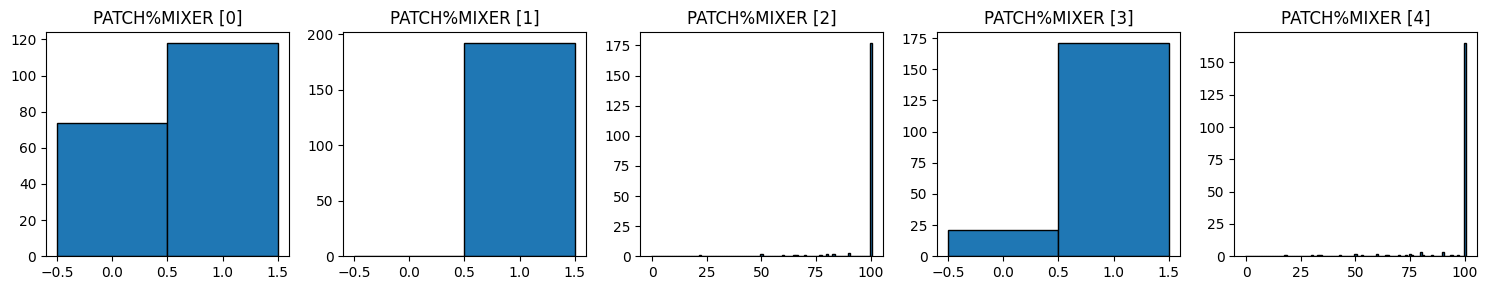

In [10]:
nvals=5
param_name='PATCH%MIXER'
fig, ax = plt.subplots(ncols=5, figsize=(nvals*3,3))

for i in range(nvals):
    param_values,param_names=plot_param_dist(i,param_name,ax=ax[i])
plt.tight_layout()
plt.show()

    

# COMPRESSOR

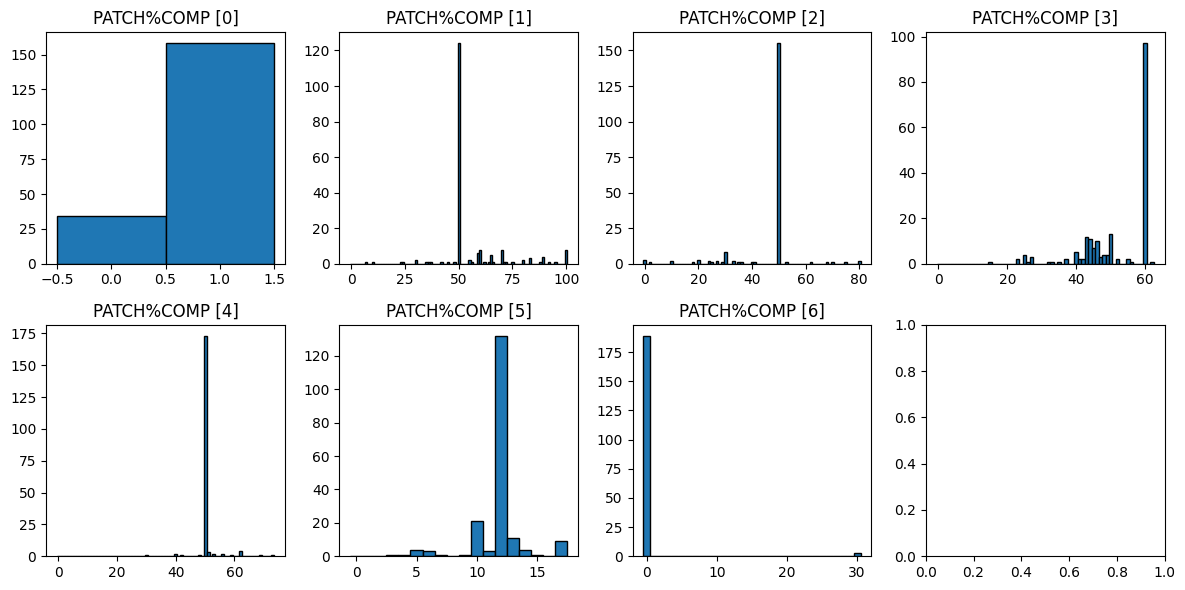

Patches by param 6 in Comp:
  0: ['SINGLE 1-01', 'SINGLE 1-02', 'SINGLE 1-03', 'SINGLE 1-04', 'SINGLE 1-05', 'SINGLE 1-06', 'SINGLE 1-07', 'SINGLE 1-08', 'SINGLE 1-09', 'SINGLE 1-10', 'SINGLE 1-11', 'SINGLE 2-01', 'SINGLE 2-02', 'SINGLE 2-03', 'SINGLE 2-04', 'SINGLE 2-05', 'SINGLE 2-06', 'SINGLE 2-07', 'SINGLE 2-08', 'SINGLE 2-09', 'SINGLE 2-10', 'SINGLE 2-11', 'DUAL 3-01', 'DUAL 3-02', 'DUAL 3-03', 'DUAL 3-04', 'DUAL 3-05', 'DUAL 3-06', 'DUAL 3-07', 'DUAL 3-08', 'DUAL 3-09', 'DUAL 3-10', 'DUAL 3-11', 'DUAL 4-01', 'DUAL 4-02', 'DUAL 4-03', 'DUAL 4-04', 'DUAL 4-05', 'DUAL 4-06', 'DUAL 4-07', 'DUAL 4-08', 'DUAL 4-09', 'DUAL 4-10', 'DUAL 4-11', 'TREMOLO 5-01', 'TREMOLO 5-02', 'TREMOLO 5-03', 'TREMOLO 5-04', 'TREMOLO 5-05', 'TREMOLO 5-06', 'TREMOLO 5-07', 'TREMOLO 5-08', 'TREMOLO 5-09', 'TREMOLO 5-10', 'TREMOLO 5-11', 'HARMONIC 6-01', 'HARMONIC 6-02', 'HARMONIC 6-03', 'HARMONIC 6-04', 'HARMONIC 6-05', 'HARMONIC 6-06', 'HARMONIC 6-07', 'HARMONIC 6-08', 'HARMONIC 6-09', 'HARMONIC 6-10', 'HAR

In [11]:
nvals=7
param_name=r'PATCH%COMP'
fig, ax = plt.subplots(ncols=4,nrows=2, figsize=(4*3,2*3))


for i in range(nvals):
    param_values,param_names=plot_param_dist(i,param_name,ax=ax.flatten()[i])

effects_names ={i : [] for i in [0,30]}
for i, name in enumerate(param_names):
    effects_names[param_values[i]].append(name)
plt.tight_layout()
plt.show()

print('Patches by param 6 in Comp:')
for i in [0,30]:
    print(f'  {i}: {effects_names[i]}')   


# PARAMETRIC EQ

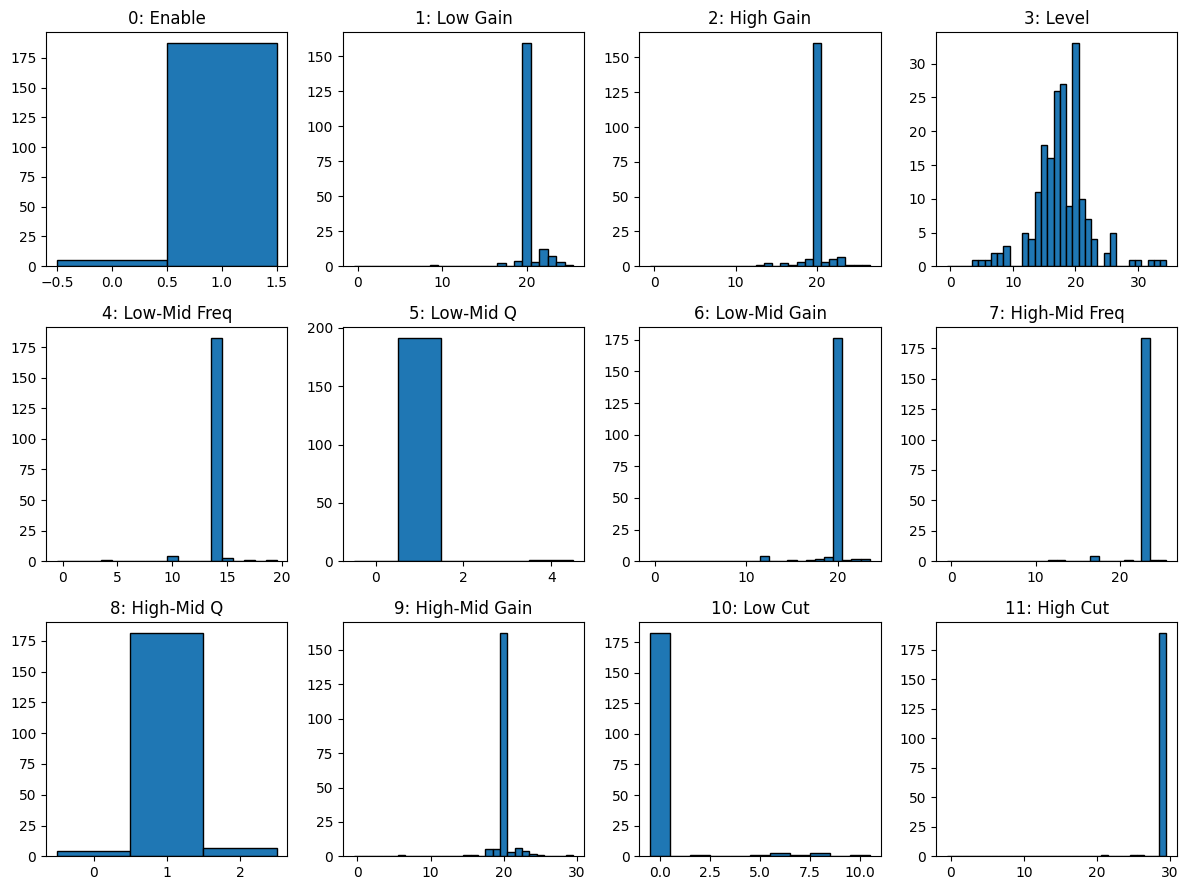

In [12]:
nvals=12
param_name=r'PATCH%PEQ'
fig, ax = plt.subplots(ncols=4,nrows=3, figsize=(4*3,3*3))
titles=[ "Enable", "Low Gain" ,"High Gain", "Level", "Low-Mid Freq", "Low-Mid Q", "Low-Mid Gain", "High-Mid Freq", "High-Mid Q", "High-Mid Gain", "Low Cut",  "High Cut",]

for i in range(nvals):
    title = f'{i}: {titles[i]}'
    param_values,param_names=plot_param_dist(i,param_name,ax=ax.flatten()[i],title=title)

plt.tight_layout()
plt.show()


# TREMOLO C1 AND C2

KeyError: 1

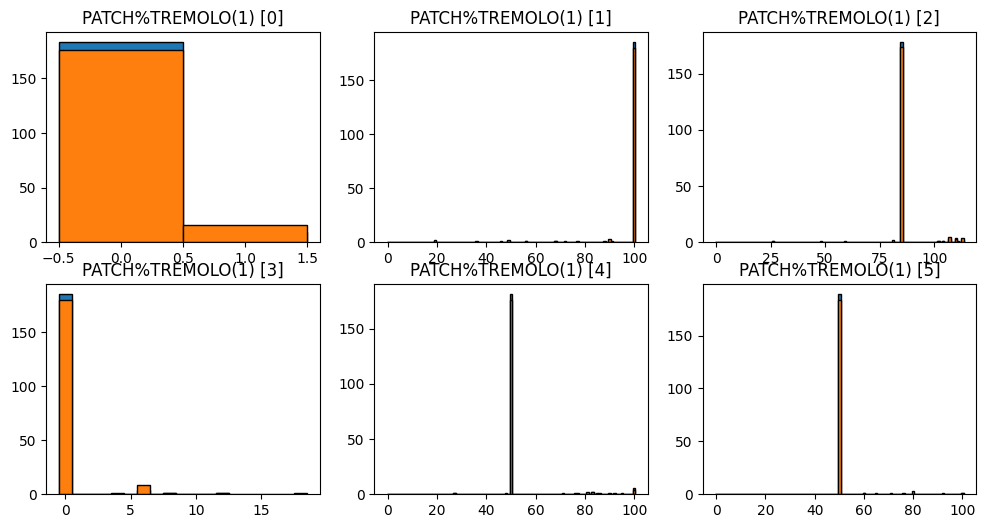

In [13]:
nvals=6
param_name=r"PATCH%TREMOLO"
fig, ax = plt.subplots(ncols=3,nrows=2, figsize=(4*3,3*2))
#titles=[ "Enable", "Low Gain" ,"High Gain", "Level", "Low-Mid Freq", "Low-Mid Q", "Low-Mid Gain", "High-Mid Freq", "High-Mid Q", "High-Mid Gain", "Low Cut",  "High Cut",]

for i in range(nvals):
    #title = f'{i}: {titles[i]}'
    param_values,param_names=plot_param_dist(i,param_name+'(2)',ax=ax.flatten()[i],)#title=title)

    param_values,param_names=plot_param_dist(i,param_name+'(1)',ax=ax.flatten()[i],)#title=title)



param_values,param_names=plot_param_dist(0,param_name+'(1)',ax=None,)
for i, name in enumerate(param_names):
    effects_names[param_values[i]].append(name)

print('Patches with tremolo engaged:')
for i in range(2):
    print(f'  {i}: {effects_names[i]}')  

plt.tight_layout()
plt.show()

# OVERTONE C1 AND C2

Patches with Overtone engaged:
  0: ['SINGLE 1-01', 'SINGLE 1-02', 'SINGLE 1-03', 'SINGLE 1-04', 'SINGLE 1-05', 'SINGLE 1-06', 'SINGLE 1-07', 'SINGLE 1-08', 'SINGLE 1-09', 'SINGLE 1-10', 'SINGLE 1-11', 'SINGLE 2-01', 'SINGLE 2-02', 'SINGLE 2-03', 'SINGLE 2-04', 'SINGLE 2-05', 'SINGLE 2-06', 'SINGLE 2-07', 'SINGLE 2-08', 'SINGLE 2-09', 'SINGLE 2-10', 'SINGLE 2-11', 'DUAL 3-01', 'DUAL 3-02', 'DUAL 3-03', 'DUAL 3-04', 'DUAL 3-05', 'DUAL 3-06', 'DUAL 3-07', 'DUAL 3-08', 'DUAL 3-09', 'DUAL 3-10', 'DUAL 3-11', 'DUAL 4-01', 'DUAL 4-02', 'DUAL 4-03', 'DUAL 4-04', 'DUAL 4-05', 'DUAL 4-06', 'DUAL 4-07', 'DUAL 4-08', 'DUAL 4-09', 'DUAL 4-10', 'DUAL 4-11', 'TREMOLO 5-10', 'HARMONIC 6-01', 'HARMONIC 6-02', 'HARMONIC 6-03', 'HARMONIC 6-04', 'HARMONIC 6-05', 'HARMONIC 6-06', 'HARMONIC 6-07', 'HARMONIC 6-08', 'HARMONIC 6-09', 'HARMONIC 6-10', 'HARMONIC 6-11', 'SFX 7-01', 'SFX 7-02', 'SFX 7-03', 'SFX 7-04', 'SFX 7-05', 'SFX 7-06', 'SFX 7-07', 'SFX 7-09', 'SFX 7-10', 'SFX 7-11', 'SFX 8-01', 'SFX 8-02', 

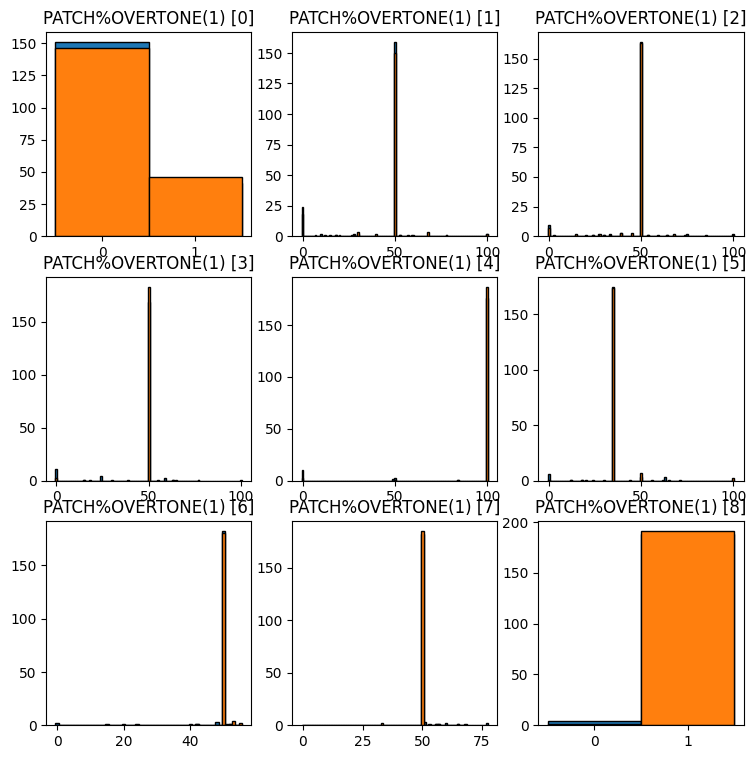

In [ ]:
nvals=9
param_name=r"PATCH%OVERTONE"
fig, ax = plt.subplots(ncols=3,nrows=3, figsize=(3*3,3*3))
#titles=[ "Enable", "Low Gain" ,"High Gain", "Level", "Low-Mid Freq", "Low-Mid Q", "Low-Mid Gain", "High-Mid Freq", "High-Mid Q", "High-Mid Gain", "Low Cut",  "High Cut",]

for i in range(nvals):
    #title = f'{i}: {titles[i]}'
    param_values,param_names=plot_param_dist(i,param_name+'(2)',ax=ax.flatten()[i],)#title=title)

    param_values,param_names=plot_param_dist(i,param_name+'(1)',ax=ax.flatten()[i],)#title=title)

plt.tight_layout()
plt.show()

param_values,param_names=plot_param_dist(0,param_name+'(1)',ax=None,)
for i, name in enumerate(param_names):
    effects_names[param_values[i]].append(name)

print('Patches with Overtone engaged:')
for i in range(2):
    print(f'  {i}: {effects_names[i]}')  



# PHASER

Patches with Phaser engaged:
  0: ['SINGLE 1-01', 'SINGLE 1-02', 'SINGLE 1-03', 'SINGLE 1-04', 'SINGLE 1-05', 'SINGLE 1-06', 'SINGLE 1-07', 'SINGLE 1-08', 'SINGLE 1-09', 'SINGLE 1-10', 'SINGLE 1-11', 'SINGLE 2-01', 'SINGLE 2-02', 'SINGLE 2-03', 'SINGLE 2-04', 'SINGLE 2-05', 'SINGLE 2-06', 'SINGLE 2-07', 'SINGLE 2-08', 'SINGLE 2-09', 'SINGLE 2-10', 'SINGLE 2-11', 'DUAL 3-01', 'DUAL 3-02', 'DUAL 3-03', 'DUAL 3-04', 'DUAL 3-05', 'DUAL 3-06', 'DUAL 3-07', 'DUAL 3-08', 'DUAL 3-09', 'DUAL 3-10', 'DUAL 3-11', 'DUAL 4-01', 'DUAL 4-02', 'DUAL 4-03', 'DUAL 4-04', 'DUAL 4-05', 'DUAL 4-06', 'DUAL 4-07', 'DUAL 4-08', 'DUAL 4-09', 'DUAL 4-10', 'DUAL 4-11', 'TREMOLO 5-10', 'HARMONIC 6-01', 'HARMONIC 6-02', 'HARMONIC 6-03', 'HARMONIC 6-04', 'HARMONIC 6-05', 'HARMONIC 6-06', 'HARMONIC 6-07', 'HARMONIC 6-08', 'HARMONIC 6-09', 'HARMONIC 6-10', 'HARMONIC 6-11', 'SFX 7-01', 'SFX 7-02', 'SFX 7-03', 'SFX 7-04', 'SFX 7-05', 'SFX 7-06', 'SFX 7-07', 'SFX 7-09', 'SFX 7-10', 'SFX 7-11', 'SFX 8-01', 'SFX 8-02', 'S

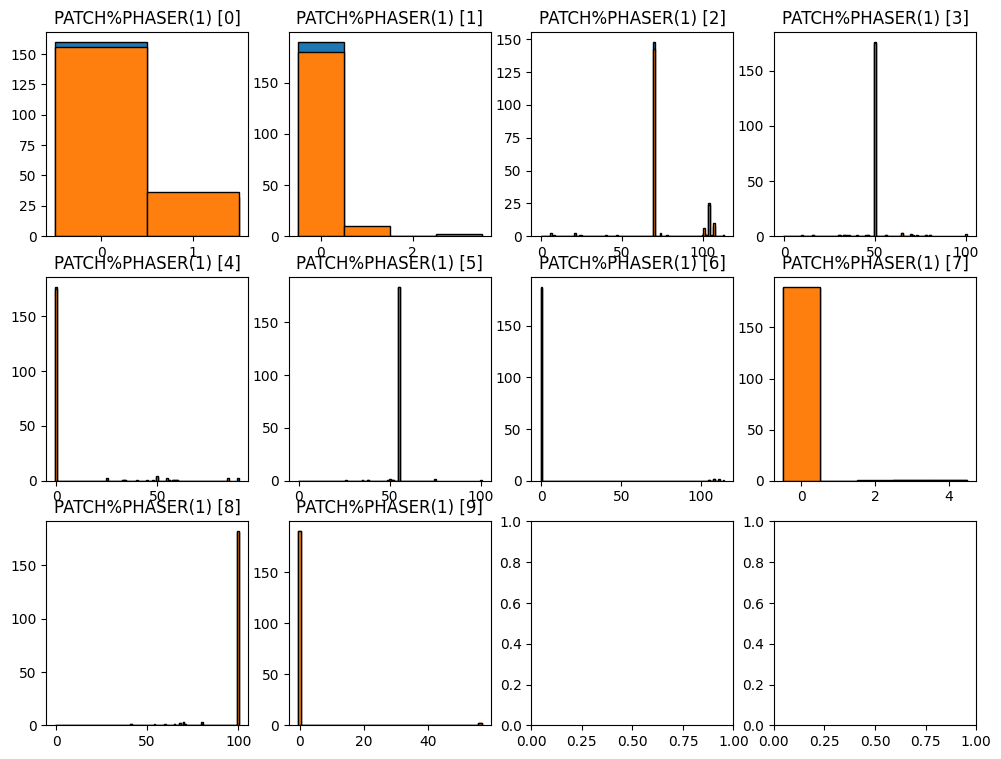

In [ ]:
nvals=10
param_name=r"PATCH%PHASER"
fig, ax = plt.subplots(ncols=4,nrows=3, figsize=(3*4,3*3))
#titles=[ "Enable", "Low Gain" ,"High Gain", "Level", "Low-Mid Freq", "Low-Mid Q", "Low-Mid Gain", "High-Mid Freq", "High-Mid Q", "High-Mid Gain", "Low Cut",  "High Cut",]

for i in range(nvals):
    #title = f'{i}: {titles[i]}'
    param_values,param_names=plot_param_dist(i,param_name+'(2)',ax=ax.flatten()[i],)#title=title)

    param_values,param_names=plot_param_dist(i,param_name+'(1)',ax=ax.flatten()[i],)#title=title)

plt.tight_layout()
plt.show()

param_values,param_names=plot_param_dist(0,param_name+'(1)',ax=None,)
for i, name in enumerate(param_names):
    effects_names[param_values[i]].append(name)

print('Patches with Phaser engaged:')
for i in range(2):
    print(f'  {i}: {effects_names[i]}')  

# FLANGER

Patches with Flanger engaged:
  0: ['SINGLE 1-01', 'SINGLE 1-02', 'SINGLE 1-03', 'SINGLE 1-04', 'SINGLE 1-05', 'SINGLE 1-06', 'SINGLE 1-07', 'SINGLE 1-08', 'SINGLE 1-09', 'SINGLE 1-10', 'SINGLE 1-11', 'SINGLE 2-01', 'SINGLE 2-02', 'SINGLE 2-03', 'SINGLE 2-04', 'SINGLE 2-05', 'SINGLE 2-06', 'SINGLE 2-07', 'SINGLE 2-08', 'SINGLE 2-09', 'SINGLE 2-10', 'SINGLE 2-11', 'DUAL 3-01', 'DUAL 3-02', 'DUAL 3-03', 'DUAL 3-04', 'DUAL 3-05', 'DUAL 3-06', 'DUAL 3-07', 'DUAL 3-08', 'DUAL 3-09', 'DUAL 3-10', 'DUAL 3-11', 'DUAL 4-01', 'DUAL 4-02', 'DUAL 4-03', 'DUAL 4-04', 'DUAL 4-05', 'DUAL 4-06', 'DUAL 4-07', 'DUAL 4-08', 'DUAL 4-09', 'DUAL 4-10', 'DUAL 4-11', 'TREMOLO 5-10', 'HARMONIC 6-01', 'HARMONIC 6-02', 'HARMONIC 6-03', 'HARMONIC 6-04', 'HARMONIC 6-05', 'HARMONIC 6-06', 'HARMONIC 6-07', 'HARMONIC 6-08', 'HARMONIC 6-09', 'HARMONIC 6-10', 'HARMONIC 6-11', 'SFX 7-01', 'SFX 7-02', 'SFX 7-03', 'SFX 7-04', 'SFX 7-05', 'SFX 7-06', 'SFX 7-07', 'SFX 7-09', 'SFX 7-10', 'SFX 7-11', 'SFX 8-01', 'SFX 8-02', '

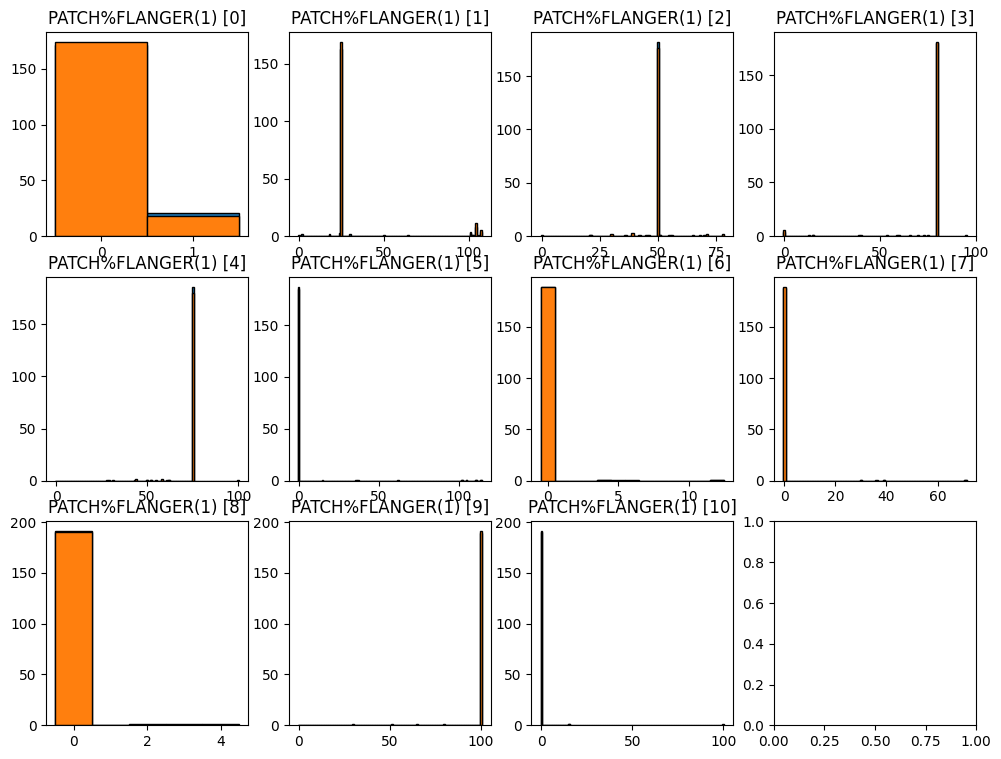

In [ ]:
nvals=11
param_name=r"PATCH%FLANGER"
fig, ax = plt.subplots(ncols=4,nrows=3, figsize=(3*4,3*3))
#titles=[ "Enable", "Low Gain" ,"High Gain", "Level", "Low-Mid Freq", "Low-Mid Q", "Low-Mid Gain", "High-Mid Freq", "High-Mid Q", "High-Mid Gain", "Low Cut",  "High Cut",]

for i in range(nvals):
    #title = f'{i}: {titles[i]}'
    param_values,param_names=plot_param_dist(i,param_name+'(2)',ax=ax.flatten()[i],)#title=title)

    param_values,param_names=plot_param_dist(i,param_name+'(1)',ax=ax.flatten()[i],)#title=title)
plt.tight_layout()
plt.show()


param_values,param_names=plot_param_dist(0,param_name+'(1)',ax=None,)
for i, name in enumerate(param_names):
    effects_names[param_values[i]].append(name)

print('Patches with Flanger engaged:')
for i in range(2):
    print(f'  {i}: {effects_names[i]}')  